**Importing libraries**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Activation

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mean_absolute_error

**Entering the Etherium dataset**

In [2]:
data = '/content/coin_Ethereum.csv'
dataset = pd.read_csv(data)
chosen_col = 'Close'
print(len(dataset))
dataset.head()

2160


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Ethereum,ETH,2015-08-08 23:59:59,2.798810,0.714725,2.793760,0.753325,674188.0,4.548689e+07
1,2,Ethereum,ETH,2015-08-09 23:59:59,0.879810,0.629191,0.706136,0.701897,532170.0,4.239957e+07
2,3,Ethereum,ETH,2015-08-10 23:59:59,0.729854,0.636546,0.713989,0.708448,405283.0,4.281836e+07
3,4,Ethereum,ETH,2015-08-11 23:59:59,1.131410,0.663235,0.708087,1.067860,1463100.0,6.456929e+07
4,5,Ethereum,ETH,2015-08-12 23:59:59,1.289940,0.883608,1.058750,1.217440,2150620.0,7.364501e+07


**Making Training and Testing data**

In [3]:
split_row = len(dataset) - int(0.2 * len(dataset))
train_data = dataset.iloc[:split_row]
test_data = dataset.iloc[split_row:]

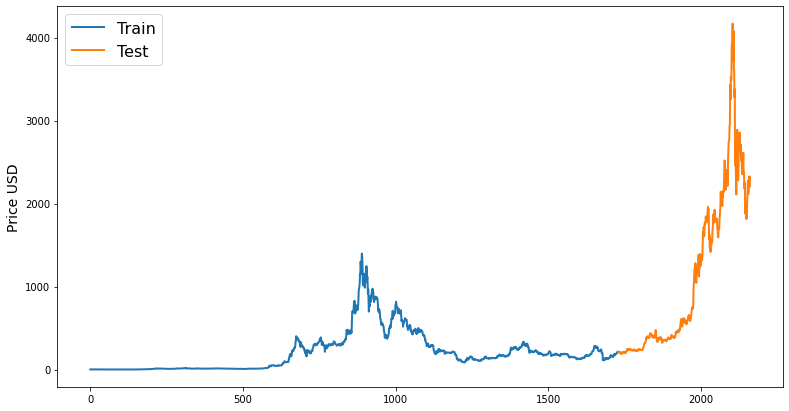

In [4]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(train_data[chosen_col], label='Train', linewidth=2)
ax.plot(test_data[chosen_col], label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [5]:
print(train_data[chosen_col].shape)

(1728,)


In [6]:
datacol = dataset.iloc[:, 7:8].values
traincol = train_data.iloc[:, 7:8].values
testcol = test_data.iloc[:, 7:8].values

shaped_data = np.reshape(datacol, (-1,1))
train_shaped = np.reshape(traincol, (-1,1))
test_shaped = np.reshape(testcol, (-1,1))

sc = MinMaxScaler(feature_range=(0,1))
sc.fit(shaped_data)

train_scaled_data = sc.transform(train_shaped)
test_scaled_data = sc.transform(test_shaped)

In [7]:
print(traincol.shape)

(1728, 1)


In [8]:
X = []
y = []
time_steps = 50

for i in range(time_steps, len(train_data)):
    X.append(train_scaled_data[i-time_steps:i,0])
    y.append(train_scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Making the model**

In [10]:
model = Sequential()
model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mse')

**Running the model**

In [11]:
callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1, callbacks=[callback], shuffle=True)

Epoch 1/100
42/42 [==============================] - 5s 57ms/step - loss: 5.9006e-04 - val_loss: 1.0731e-04
Epoch 2/100
42/42 [==============================] - 2s 42ms/step - loss: 1.2917e-04 - val_loss: 1.1092e-04
Epoch 3/100
42/42 [==============================] - 2s 43ms/step - loss: 1.3931e-04 - val_loss: 8.5686e-05
Epoch 4/100
42/42 [==============================] - 2s 42ms/step - loss: 1.2668e-04 - val_loss: 8.7286e-05
Epoch 5/100
42/42 [==============================] - 2s 43ms/step - loss: 1.0669e-04 - val_loss: 7.8201e-05
Epoch 6/100
42/42 [==============================] - 2s 43ms/step - loss: 1.1066e-04 - val_loss: 7.2437e-05
Epoch 7/100
42/42 [==============================] - 2s 43ms/step - loss: 8.9999e-05 - val_loss: 7.0870e-05
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 1.1127e-04 - val_loss: 9.6416e-05
Epoch 9/100
42/42 [==============================] - 2s 43ms/step - loss: 1.0992e-04 - val_loss: 6.4366e-05
Epoch 10/100
42/42 [========

loss and validation loss both are decreasing therefore the model is performing well

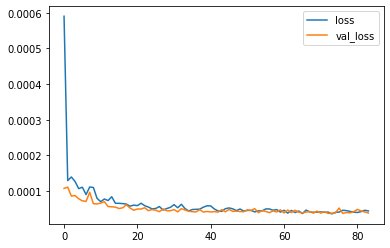

In [12]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()

This clearly shows that the model is neither overfitting nor underfitting

In [13]:
X_testing = []
y_testing = []

for i in range(time_steps, len(test_data)):
    X_testing.append(test_scaled_data[i-time_steps:i,0])
    y_testing.append(test_scaled_data[i, 0])

X_testing, y_testing = np.array(X_testing), np.array(y_testing)
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

predicted_price = model.predict(X_testing)
inv_price = sc.inverse_transform(predicted_price)
real_price = np.reshape(y_testing, (-1,1))
real_price = sc.inverse_transform(real_price)

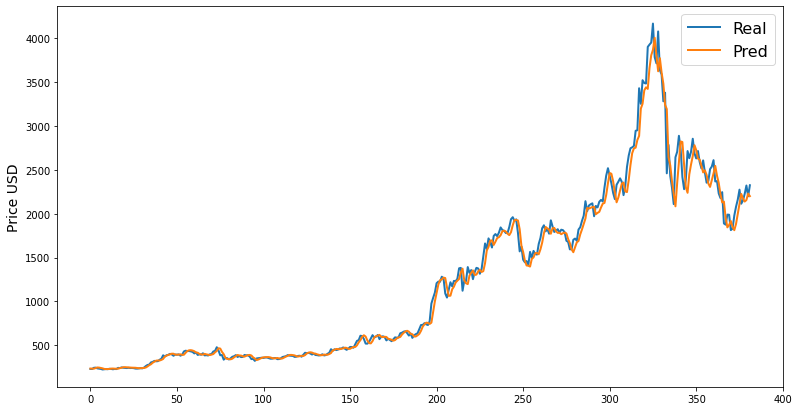

In [14]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(real_price, label='Real', linewidth=2)
ax.plot(inv_price, label='Pred', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

**Now we will test this model on a different dataset of Bitcoin**

In [15]:
model.save("crypto_pred.h5")

In [16]:
from tensorflow import keras
new_model = keras.models.load_model('crypto_pred.h5')

In [17]:
data = '/content/coin_Bitcoin.csv'
dataset = pd.read_csv(data)
chosen_col = 'Close'
print(len(dataset))
split_row = len(dataset) - int(0.2 * len(dataset))
train_data = dataset.iloc[:split_row]
test_data = dataset.iloc[split_row:]
datacol = dataset.iloc[:, 7:8].values
traincol = train_data.iloc[:, 7:8].values
testcol = test_data.iloc[:, 7:8].values

shaped_data = np.reshape(datacol, (-1,1))
train_shaped = np.reshape(traincol, (-1,1))
test_shaped = np.reshape(testcol, (-1,1))

sc = MinMaxScaler(feature_range=(0,1))
sc.fit(shaped_data)

train_scaled_data = sc.transform(train_shaped)
test_scaled_data = sc.transform(test_shaped)
X = []
y = []
time_steps = 50

for i in range(time_steps, len(train_data)):
    X.append(train_scaled_data[i-time_steps:i,0])
    y.append(train_scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X_testing = []
y_testing = []

for i in range(time_steps, len(test_data)):
    X_testing.append(test_scaled_data[i-time_steps:i,0])
    y_testing.append(test_scaled_data[i, 0])

X_testing, y_testing = np.array(X_testing), np.array(y_testing)
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))
predicted_price = new_model.predict(X_testing)
inv_price = sc.inverse_transform(predicted_price)
real_price = np.reshape(y_testing, (-1,1))
real_price = sc.inverse_transform(real_price)

2991


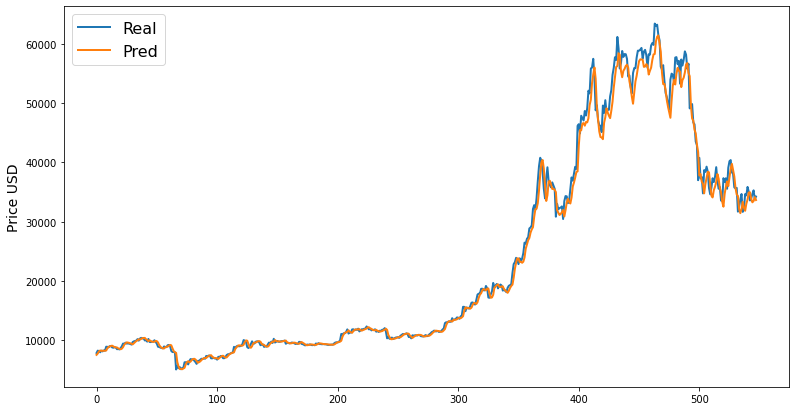

In [18]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(real_price, label='Real', linewidth=2)
ax.plot(inv_price, label='Pred', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

**Hence as observed, the model gives very accurate predictions on a new dataset**